In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

import jlinops
import sampi

# Toy problem

In [31]:
ground_truth = 0.1*jlinops.piecewise_constant_1d_test_problem() + 1.0
#ground_truth = jlinops.comp_emp_bayes_t1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
L = 20
noisy_signal = ground_truth*np.random.gamma(shape=L, scale=1/L, size=ground_truth.shape)
grid = np.arange(n)

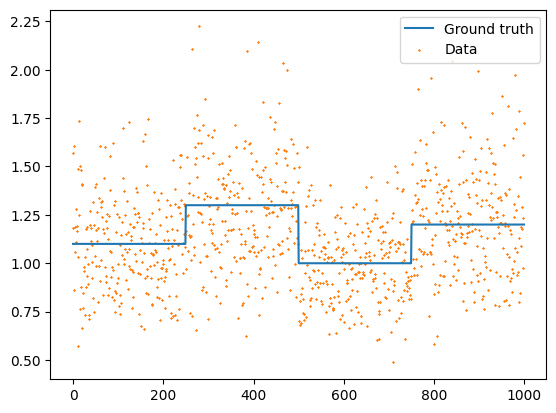

In [32]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [33]:
# Log transformation
log_noisy_signal = np.log(noisy_signal)

# IAS method

In [34]:

class DespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, R, y, hyperparams, L=1, pdata={}):

        # Bind
        self.y = y
        self.R = R
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, x0=None, n_newton_steps=10, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if x0 is None:
            x = np.ones(self.n)
        else:
            x = x0
        
        # Handle warmstarting
        if warmstarting:
            x_prev = x.copy()
        else:
            x_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        
        
        # Iterate
        for j in range(max_iters):
            
            # Update prior thetas
            theta_curr = self.theta_update(x)

            # Update x
            x = self.x_update(theta_curr, n_newton_steps=n_newton_steps, x_prev=x_prev)
            if warmstarting:
                x_prev = x.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(x, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "x": x,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters
        }

        return data



    def x_update(self, theta, n_newton_steps=10, x_prev=None):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        # Initialization
        if x_prev is not None:
            x = x_prev
        else:
            x = np.ones(self.n)

        # Only doing non-priorconditioned version for now
        for j in range(n_newton_steps):

            # Build gradient
            gradient = self.L*(1 - np.exp(self.y - x)) + Rtilde.rmatvec(Rtilde.matvec(x))

            # Build hessian
            Q = jlinops.DiagonalOperator( self.L*np.exp(self.y-x) ) + (Rtilde.T @ Rtilde)

            # Solve
            self.nsolve, _ = cg(Q, gradient, tol=1e-3, x0=self.nsolve)
            x -= self.nsolve

        return x


    # def x_update(self, theta, noise_var, priorconditioning=False, x_update_solver_params={}, x_prev=None):
    #     """Returns the x-update for fixed local variance parameters theta.
    #     """
        
    #     # Whiten forward operator and data
    #     noise_stdev = np.sqrt(noise_var)
    #     Ftilde = (1.0/noise_stdev)*self.F
    #     ytilde = (1.0/noise_stdev)*self.y
        
    #     # Build Rtilde
    #     Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

    #     # If not using priorconditioning, solve original problem using CGLS without standardizing
    #     if not priorconditioning:
            
    #         # Solve using cgls
    #         cgls_solve = jlinops.trlstsq(Ftilde, Rtilde, ytilde, lam=1.0, initialization=x_prev, **x_update_solver_params)
    #         return cgls_solve["x"], cgls_solve["n_iters"]
        
    #     # If using priorconditioning
    #     else:
            
    #         # Build current Rpinv operator
    #         Rpinv = self.pdata["Rpinv_factory"](theta)
            
    #         # Solve using transformed CGLS
    #         cgls_solve = jlinops.trlstsq_standard_form(Ftilde, ytilde, Rpinv=Rpinv, R=Rtilde,
    #                                                    AWpinv=self.pdata["FWpinv"], lam=1.0, shift=None, W=self.pdata["W"], initialization=x_prev, **x_update_solver_params)
    #         return cgls_solve["x"], cgls_solve["n_iters"]
        
        
        
    def theta_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (x) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, x, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        ft_likeihood = self.L*( np.exp(self.y - x) + x - self.y ).sum()
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ x)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = ft_likeihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        
    



In [53]:
# Define forward operator and regularization matrix
R, W = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(W)
R = jlinops.MatrixLinearOperator(R)

In [54]:
# Prior parameters
# reg_lambda = 1e1
# vartheta = 2/(reg_lambda**2)
# hyperparams = {
#     "prior": {
#         "r": 1.0,
#         "beta": 1.5 + 1e-3,
#         "vartheta": vartheta,
#     },
# }

hyperparams = {
    "prior": {
        "r": 0.5,
        "beta": 3 + 1e-1,
        "vartheta": 1e-4,
    },
}

# Create solver
solver = DespecklingIASSolver(R, log_noisy_signal, hyperparams, L=L, pdata={})

In [55]:
data = solver.solve(max_iters=20, x0=log_noisy_signal, 
                    n_newton_steps=10, warmstarting=True, eps=1e-3,
                    early_stopping=True,)

In [39]:
data["converged"]

True

In [40]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'n_iters'])

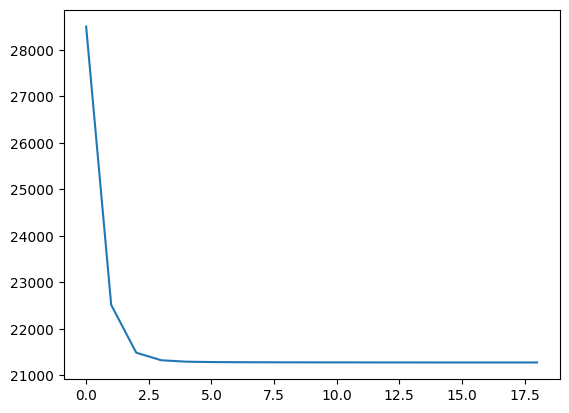

In [41]:
plt.plot(data["obj_vals"])
plt.show()

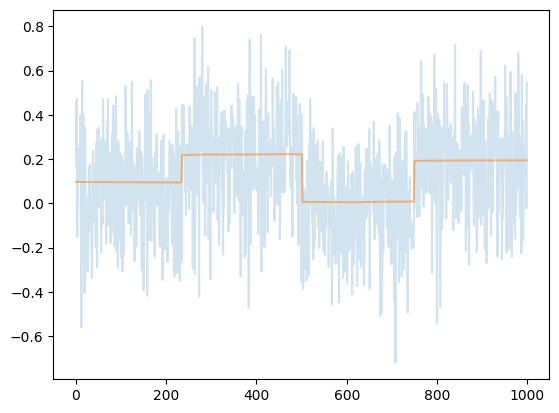

In [42]:
plt.plot(log_noisy_signal, alpha=0.2)
plt.plot(data["x"], alpha=0.5)
plt.show()

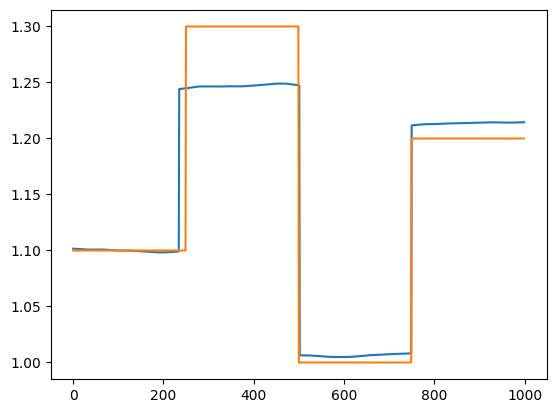

In [43]:
plt.plot(np.exp(data["x"]))
plt.plot(ground_truth)
plt.show()

# Hybrid IAS?

In [45]:
# Prior parameters

r_target = 0.5
beta_target = 3 + 1e-1
vartheta_target = 1e-4
r_init = 1.0

beta_init, vartheta_init = sampi.ias_parameter_switch(r_init, r_target, beta_target, vartheta_target)

hyperparams = {
    "prior": {
        "r": r_init,
        "beta": beta_init,
        "vartheta": vartheta_init,
    },
}

# Create solver
solver = DespecklingIASSolver(R, log_noisy_signal, hyperparams, L=L, pdata={})

In [46]:
# Initial convex solve
init_data = solver.solve(max_iters=20, x0=log_noisy_signal, 
                    n_newton_steps=10, warmstarting=True, eps=1e-3,
                    early_stopping=True,)

In [47]:
init_data["converged"]

False

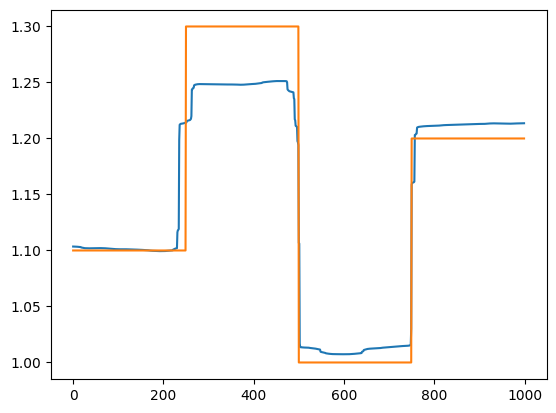

In [48]:
plt.plot(np.exp(init_data["x"]))
plt.plot(ground_truth)
plt.show()

In [49]:
# Second nonconvex solve
hyperparams = {
    "prior": {
        "r": r_target,
        "beta": beta_target,
        "vartheta": vartheta_target,
    },
}

solver = DespecklingIASSolver(R, log_noisy_signal, hyperparams, L=L, pdata={})

data = solver.solve(max_iters=20, x0=init_data["x"], 
                    n_newton_steps=10, warmstarting=True, eps=1e-3,
                    early_stopping=True,)

In [50]:
data["converged"]

False

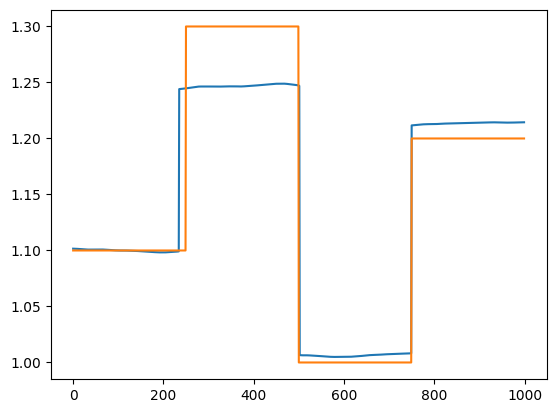

In [52]:
plt.plot(np.exp(data["x"]))
plt.plot(ground_truth)
plt.show()

# Newton method

In [ ]:
def newtons_method(jac_fn, grad_fn, x0=None, tol=1e-3, maxits=20, n=None):
    """Performs newton iterates until convergence criterion is met.
    """

    if x0 is None:
        return None
    